In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
from scipy import stats
import math

import statsmodels.api as sm
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, normalize
from sklearn.metrics import r2_score, mean_absolute_error

### Error Functions

In [2]:
def mae_value(X_test,y_test, model, ):
    '''
    return MAE of a model based on test data
    '''
    #test_set_pred = lasso_model.predict(X_test.loc[:,selected_columns])
    yhat = model.predict(X_test)

    #mae
    return mean_absolute_error(y_test, yhat)

def adjusted_r2_value( X_test,y_test,model):
    '''
    return r2 of a model based on test data
    '''
    #test_set_pred = lasso_model.predict(X_test.loc[:,selected_columns])
    yhat = model.predict(X_test)
    
    adjusted_r2 = 1 - (1-r2_score(y_test, yhat))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    #adjusted_r2 = 1 - (1-model.score(X_test,y_test))*((len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
    
    return adjusted_r2

def r2_value( X_test,y_test,model):
    '''
    return r2 of a model based on test data
    '''
    #test_set_pred = lasso_model.predict(X_test.loc[:,selected_columns])
    yhat = model.predict(X_test)
    
    return r2_score(y_test, yhat)

### Plotting and Coefficients

In [3]:
def plot_pred_vs_actual(X_test,y_test, model):
    '''
    plot y prediction against y test
    '''
    #test_set_pred = lasso_model.predict(X_test.loc[:,selected_columns])
    yhat = model.predict(X_test)
    
    #format plot
    plt.rcParams.update({'font.size': 12})    
    plt.title("Predicted VS Actual")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.figure(figsize=(10,5))
    
    #plot 
    plt.scatter(yhat, y_test, alpha=.2, color = '#3468bc')
    plt.plot(np.linspace(0,100000,1000), np.linspace(0,150000,1000))
    x_plot = np.linspace(0, 1, 100)
    
def diagnostic_plot(X, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(X,y)
    pred = rgr.predict(X)

    plt.subplot(1, 3, 1)
    plt.scatter(X,y)
    plt.plot(X, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")
    
def get_feature_coefs(model,linear,X_train):
    #linear coefs
    if linear:
        print('Feature coefficient results: \n')
        for feature, coef in zip(X_train.columns, model.coef_):
            print(f'Coef of {feature} is : {coef:.2f}')

        return zip(X_train.columns, model.coef_)
    #poly coef
    else:
        print('Feature coefficient results: \n')
        for feature, coef in zip(model.get_feature_names(), model.coef_):
            print( f'Coef of {feature} is : {coef:.2f}')

        return zip(model.get_feature_names(), model.coef_)   

### Regression Functions with Cross Validation

In [4]:
def linear_regression_with_cv(X_train, y_train):
    '''
    print r2 val score and feature coefficient results
    return model
    '''
    #this helps with the way kf will generate indices below
    X, y = np.array(X_train), np.array(y_train)
    kf = KFold(n_splits=5, shuffle=True, random_state = 71) #randomly shuffle before splitting
    r2_train = []
    r2_adj = [] #collect the adj val r2 results
    r2_val = [] #collect the val r2 results
    mae = [] #collect mae results
    
    #returns 5 index sets for cross vallidation
    for train_ind, val_ind in kf.split(X,y):
    
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 
        
        #simple linear regression
        lm = LinearRegression()
        lm.fit(X_train, y_train)
        r2_train.append(round(r2_value(X_train, y_train, lm), 3))
        r2_adj.append(round(adjusted_r2_value(X_val, y_val, lm), 3))
        r2_val.append(round(r2_value(X_val, y_val, lm), 3))
        mae.append(round(mae_value(X_val, y_val, lm),3))
        
    #report results
    print(f'Simple mean cv r^2 train score: {np.mean(r2_train):.3f} +- {np.std(r2_train):.3f}')
    print(f'Simple mean cv r^2 val score: {np.mean(r2_val):.3f} +- {np.std(r2_val):.3f}')
    print(f'Simple mean cv adjusted r^2 val score: {np.mean(r2_adj):.3f} +- {np.std(r2_adj):.3f}')
    print(f'Simple mean cv mae: {np.mean(mae):.3f} +- {np.std(mae):.3f}')
    
    return lm

def polynomial_regression_with_cv(X_train, y_train, degree, interaction):
    '''
    print r2 val score and polynomial feature coefficient results
    return model
    '''
    #this helps with the way kf will generate indices below
    X, y = np.array(X_train), np.array(y_train)
    kf = KFold(n_splits=5, shuffle=True, random_state = 71) #randomly shuffle before splitting
    r2_train = []
    r2_adj = [] #collect the adj val results
    r2_val = [] #collect the validation results
    mae = [] #collect mae results
    
    #returns 5 index sets for cross vallidation
    for train_ind, val_ind in kf.split(X,y):
    
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 
        
        #create polynomial features
        poly = PolynomialFeatures(degree=degree, interaction_only = interaction)
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.transform(X_val)
        
        #fit poly features to linear regression to training data
        lm_poly = LinearRegression()
        lm_poly.fit(X_train_poly, y_train)
        r2_adj.append(round(adjusted_r2_value(X_val_poly, y_val, lm_poly), 3))
        r2_val.append(round(r2_value( X_val_poly,y_val, lm_poly), 3))
        r2_train.append(round(r2_value( X_train_poly,y_train, lm_poly), 3))
        mae.append(round(mae_value(X_val_poly,y_val, lm_poly),3))
    
    #report results
    print(f'Results for {degree} degree, interaction_only = {interaction} polynomial regression:')
    print(f'Simple mean cv r^2 train score: {np.mean(r2_train):.3f} +- {np.std(r2_train):.3f}')
    print(f'Simple mean cv r^2 val score: {np.mean(r2_val):.3f} +- {np.std(r2_val):.3f}')
    print(f'Simple mean cv adjusted r^2 val score: {np.mean(r2_adj):.3f} +- {np.std(r2_adj):.3f}')
    print(f'Simple mean cv mae: {np.mean(mae):.3f} +- {np.std(mae):.3f}')
    
    return lm_poly

### Manual Lasso and Ridge

In [5]:
def manual_ridge_cv(X_train, y_train, alpha):   
    #this helps with the way kf will generate indices below
    X, y = np.array(X_train), np.array(y_train)
    kf = KFold(n_splits=5, shuffle=True, random_state=23) #randomly shuffle before splitting
    r2_train, r2_val, r2_adj, mae = [], [], [], []

    for train_ind, val_ind in kf.split(X, y):
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind]

        l_ridge = Ridge(alpha=alpha)
        l_ridge.fit(X_train, y_train)

        r2_train.append(round(r2_value( X_train, y_train, l_ridge), 3))
        r2_val.append(round(r2_value( X_val, y_val, l_ridge), 3))
        r2_adj.append(round(adjusted_r2_value(X_val, y_val, l_ridge),3))
        mae.append(round(mae_value(X_val, y_val, l_ridge),3))

    print(f'Ridge regression results for aplpha = {alpha}:\n'
          f'R^2 Train: {np.mean(r2_train)},\n'
          f'R^2 Val: {np.mean(r2_val)},\n'
          f'Adjusted R^2 Val: {np.mean(r2_adj)},\n'
          f'MAE: {np.mean(mae)},')
    
    return l_ridge
    
def manual_lasso_cv(X_train, y_train, alpha):   
    #this helps with the way kf will generate indices below
    X, y = np.array(X_train), np.array(y_train)
    kf = KFold(n_splits=5, shuffle=True, random_state=23) #randomly shuffle before splitting
    r2_train, r2_val, r2_adj, mae = [], [], [], []

    for train_ind, val_ind in kf.split(X, y):
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind]

        l_lasso = Lasso(alpha=alpha)
        l_lasso.fit(X_train, y_train)

        r2_train.append(round(r2_value( X_train, y_train, l_lasso), 3))
        r2_val.append(round(r2_value( X_val, y_val, l_lasso), 3))
        r2_adj.append(round(adjusted_r2_value(X_val, y_val, l_lasso),3))
        mae.append(round(mae_value(X_val, y_val, l_lasso),3))

    print(f'Lasso regression results for aplpha = {alpha}:\n'
          f'R^2 Train: {np.mean(r2_train)},\n'
          f'R^2 Val: {np.mean(r2_val)},\n'
          f'Adjusted R^2 Val: {np.mean(r2_adj)},\n'
          f'MAE: {np.mean(mae)},')
    
    return l_lasso

### Manual Scaled Lasso and Ridge

In [6]:
def manual_scaled_ridge_cv(X_train, y_train, alpha):   
    #this helps with the way kf will generate indices below
    X, y = np.array(X_train), np.array(y_train)
    kf = KFold(n_splits=5, shuffle=True, random_state=23) #randomly shuffle before splitting
    r2_train, r2_val, r2_adj, mae = [], [], [], []

    for train_ind, val_ind in kf.split(X, y):
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind]
        
        scaler = StandardScaler(with_mean=False)
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        l_ridge = Ridge(alpha=alpha)
        l_ridge.fit(X_train_scaled, y_train)

        r2_train.append(round(r2_value( X_train_scaled, y_train, l_ridge), 3))
        r2_val.append(round(r2_value( X_val_scaled, y_val, l_ridge), 3))
        r2_adj.append(round(adjusted_r2_value(X_val_scaled, y_val, l_ridge),3))
        mae.append(round(mae_value(X_val_scaled, y_val, l_ridge),3))

    print(f'Ridge regression results for aplpha = {alpha}:\n'
          f'R^2 Train: {np.mean(r2_train)},\n'
          f'R^2 Val: {np.mean(r2_val)},\n'
          f'Adjusted R^2 Val: {np.mean(r2_adj)},\n'
          f'MAE: {np.mean(mae)},')
    
    return l_ridge
    
def manual_scaled_lasso_cv(X_train, y_train, alpha):   
    #this helps with the way kf will generate indices below
    X, y = np.array(X_train), np.array(y_train)
    kf = KFold(n_splits=5, shuffle=True, random_state=23) #randomly shuffle before splitting
    r2_train, r2_val, r2_adj, mae = [], [], [], []

    for train_ind, val_ind in kf.split(X, y):
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind]
        
        scaler = StandardScaler(with_mean=False)
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        l_lasso = Lasso(alpha=alpha)
        l_lasso.fit(X_train_scaled, y_train)

        r2_train.append(round(r2_value( X_train_scaled, y_train, l_lasso), 3))
        r2_val.append(round(r2_value( X_val_scaled, y_val, l_lasso), 3))
        r2_adj.append(round(adjusted_r2_value(X_val_scaled, y_val, l_lasso),3))
        mae.append(round(mae_value(X_val_scaled, y_val, l_lasso),3))

    print(f'Lasso regression results for aplpha = {alpha}:\n'
          f'R^2 Train: {np.mean(r2_train)},\n'
          f'R^2 Val: {np.mean(r2_val)},\n'
          f'Adjusted R^2 Val: {np.mean(r2_adj)},\n'
          f'MAE: {np.mean(mae)},')
    
    return l_lasso

### LASSO and RidgeCV

In [7]:
def scaled_ridge_cv(folds, alpha_start, alpha_end, alpha_step, X_train, y_train, X_test, y_test):
    '''
    build ridge model, no features discarded and colinear features should have equal weight
    '''
    #scale data
    std = StandardScaler(with_mean=False)
    X_train_scaled = std.fit_transform(X_train)
    X_test_scaled = std.transform(X_test)
    
    cv = RepeatedKFold(n_splits=folds, n_repeats=5, random_state=10)
    # define model
    model = RidgeCV(alphas=np.arange(alpha_start, alpha_end, alpha_step), cv=cv, normalize=False)
    # fit model
    model.fit(X_train_scaled, y_train)
    
    print(f'Alpha: {model.alpha_}')
    print(f'MAE test value: {mae_value(X_test_scaled, y_test,  model)}')
    print(f'Adjusted r2 test score: {adjusted_r2_value( X_test_scaled,y_test, model)}') 
    print(f'R2 test score: {r2_value( X_test_scaled,y_test, model)}')
    print(f'R2 train score: {r2_value( X_train_scaled,y_train, model)}')
    
    return model

def scaled_lasso_cv(folds, alpha_start, alpha_end, alpha_step, X_train, y_train, X_test, y_test):  
    '''
    print optimized alpha of LassoCV val r2 train and r2 train mean 
    return model 
    '''
    #scale data
    std = StandardScaler(with_mean=False)
    X_train_scaled = std.fit_transform(X_train)
    X_test_scaled = std.transform(X_test)
    
    cv = RepeatedKFold(n_splits=folds, n_repeats=5, random_state=10)
    # define model
    model = LassoCV(alphas=np.arange(alpha_start, alpha_end, alpha_step), cv=cv, normalize=False)
    # fit model
    model.fit(X_train_scaled, y_train)
    
    print(f'Alpha: {model.alpha_}')
    print(f'MAE test value: {mae_value(X_test_scaled, y_test,  model)}')
    print(f'Adjusted r2 test score: {adjusted_r2_value( X_test_scaled,y_test, model)}') 
    print(f'R2 test score: {r2_value( X_test_scaled,y_test, model)}')
    print(f'R2 train score: {r2_value( X_train_scaled,y_train, model)}')
    
    return model

### Load Data

In [8]:
df = pd.read_pickle('../data/model_spec_sales_df.pkl')

df1 = df.loc[:,['Model','Class', 'doors', 'passengers','price', 'speed_sec', 'horsepower_hp', 'drive', 'mpg', 'engine', 'tank_gal',
                'length_in', 'width_in','height_in', 'wheelbase_in', 'Total_Sales']]
df1 = df1.dropna() #drop rows with null values
df1.info() #check for no null values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1209 entries, 324 to 4438
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Model          1209 non-null   object 
 1   Class          1209 non-null   object 
 2   doors          1209 non-null   object 
 3   passengers     1209 non-null   object 
 4   price          1209 non-null   float64
 5   speed_sec      1209 non-null   float64
 6   horsepower_hp  1209 non-null   float64
 7   drive          1209 non-null   object 
 8   mpg            1209 non-null   float64
 9   engine         1209 non-null   object 
 10  tank_gal       1209 non-null   float64
 11  length_in      1209 non-null   float64
 12  width_in       1209 non-null   float64
 13  height_in      1209 non-null   float64
 14  wheelbase_in   1209 non-null   float64
 15  Total_Sales    1209 non-null   float64
dtypes: float64(10), object(6)
memory usage: 160.6+ KB


In [9]:
#find unique models
df1['Model'].nunique()

301

## EDA

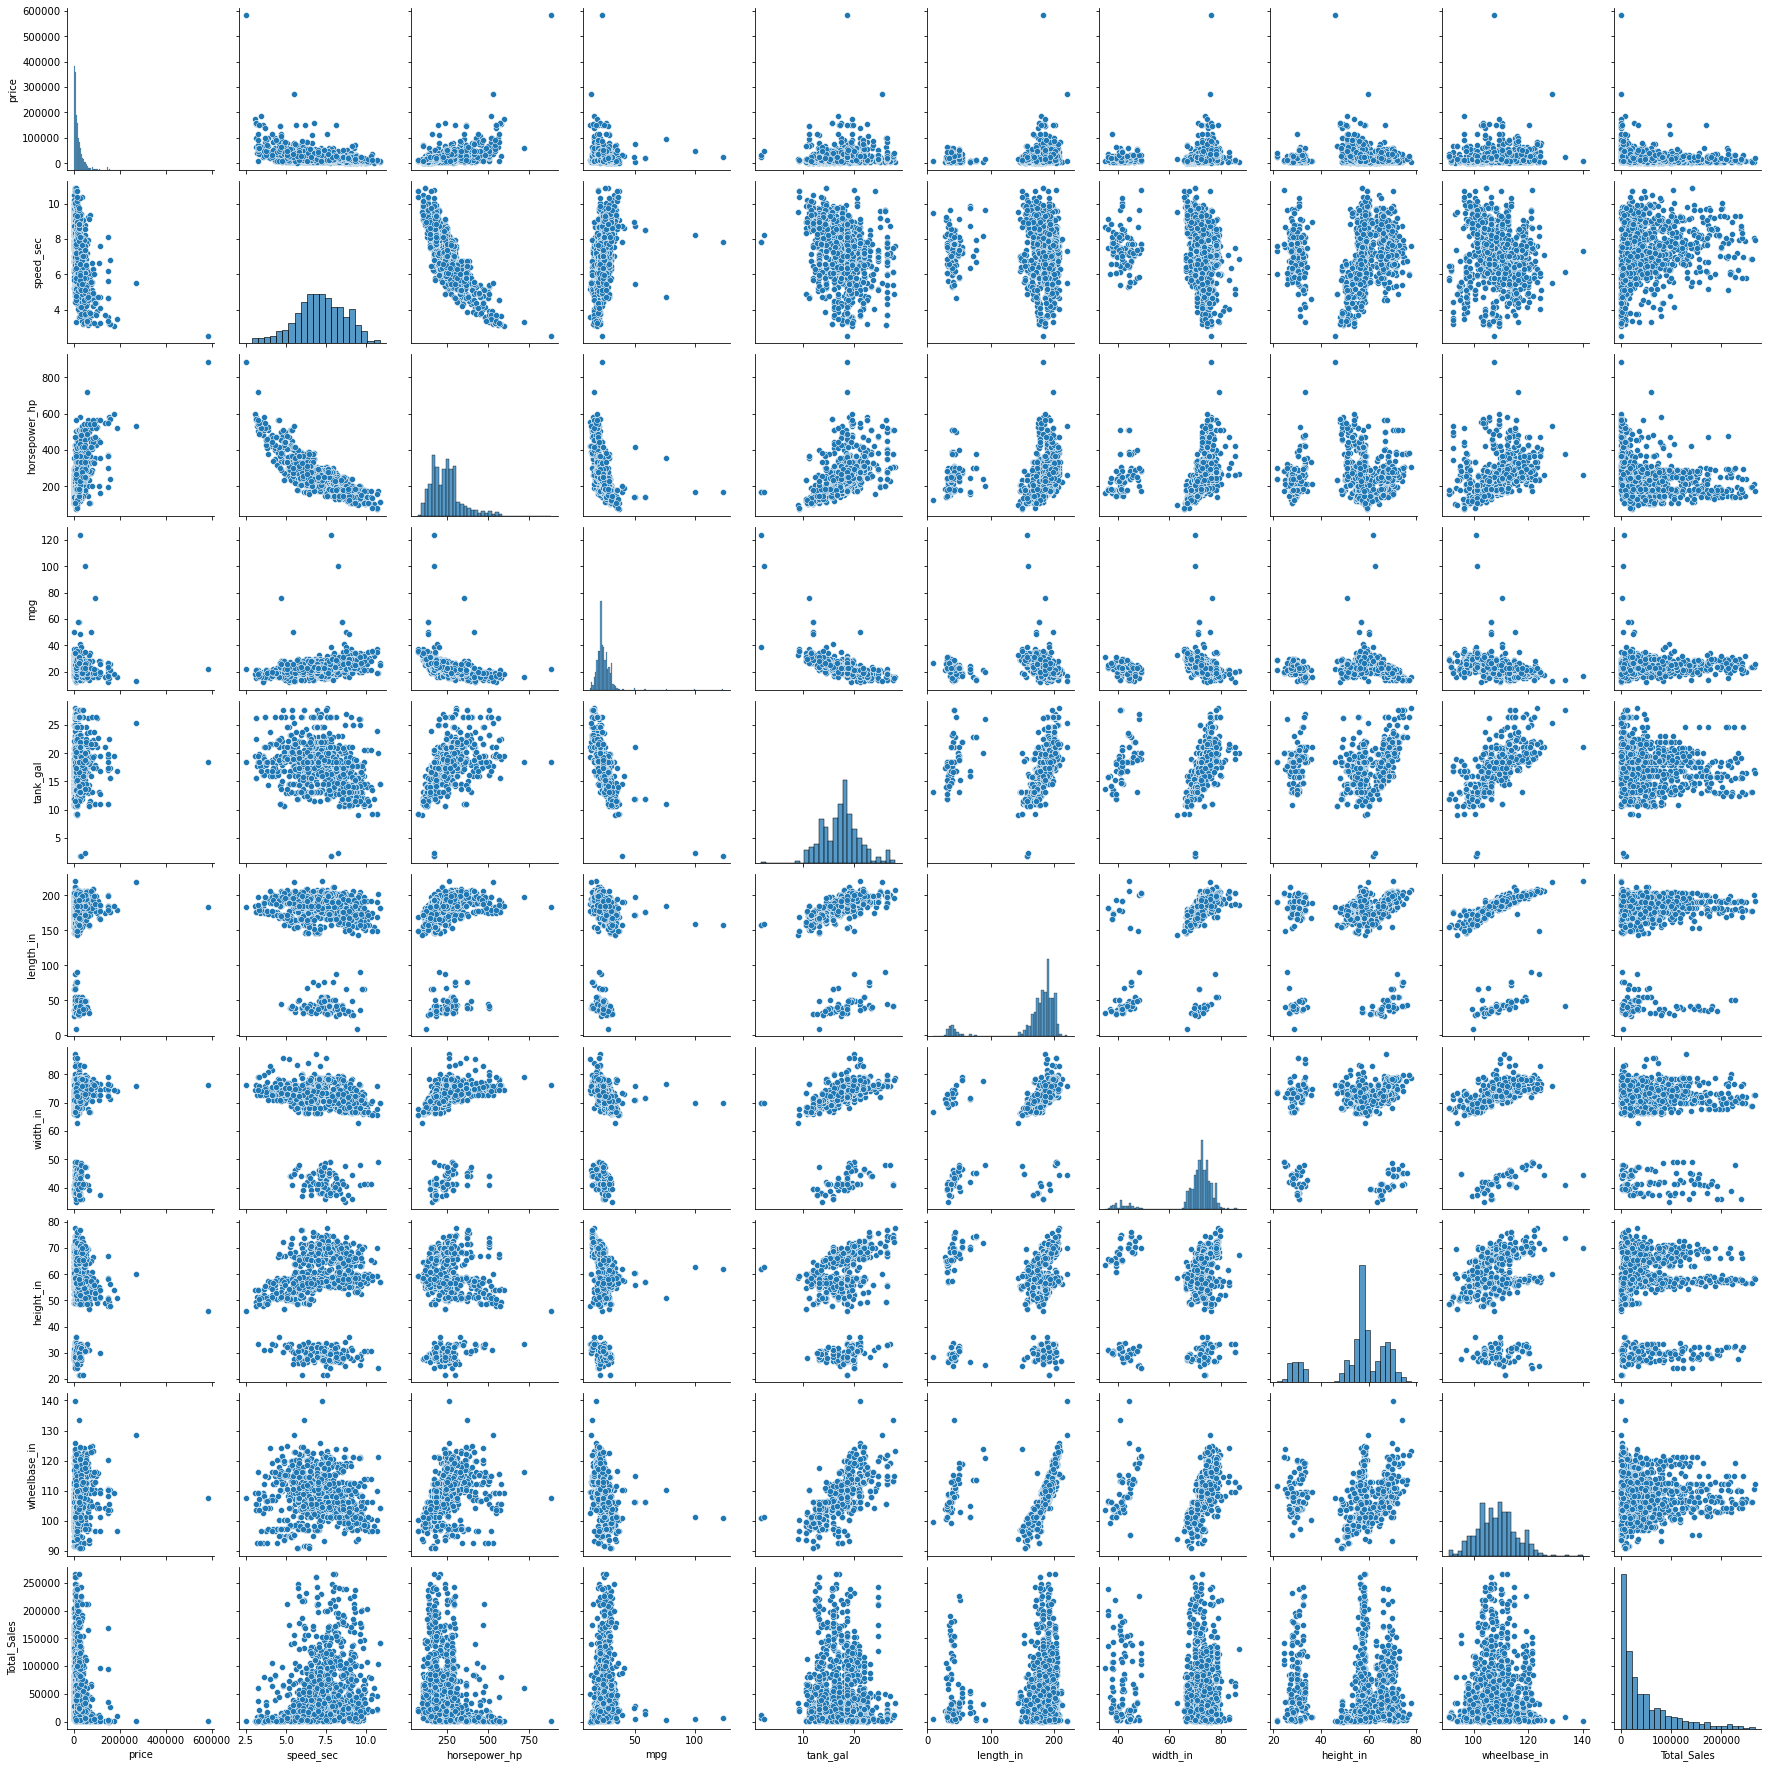

In [10]:
sns.pairplot(df1)

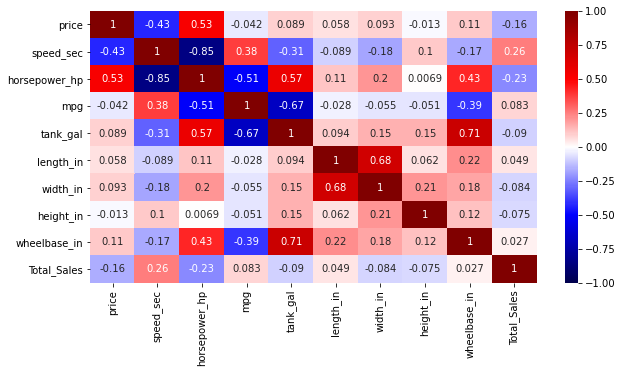

In [11]:
plt.figure(figsize=(10,5))
sns.heatmap(df1.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

Check categorical features to see if it is related to Total Sales

<AxesSubplot:xlabel='passengers', ylabel='Count'>

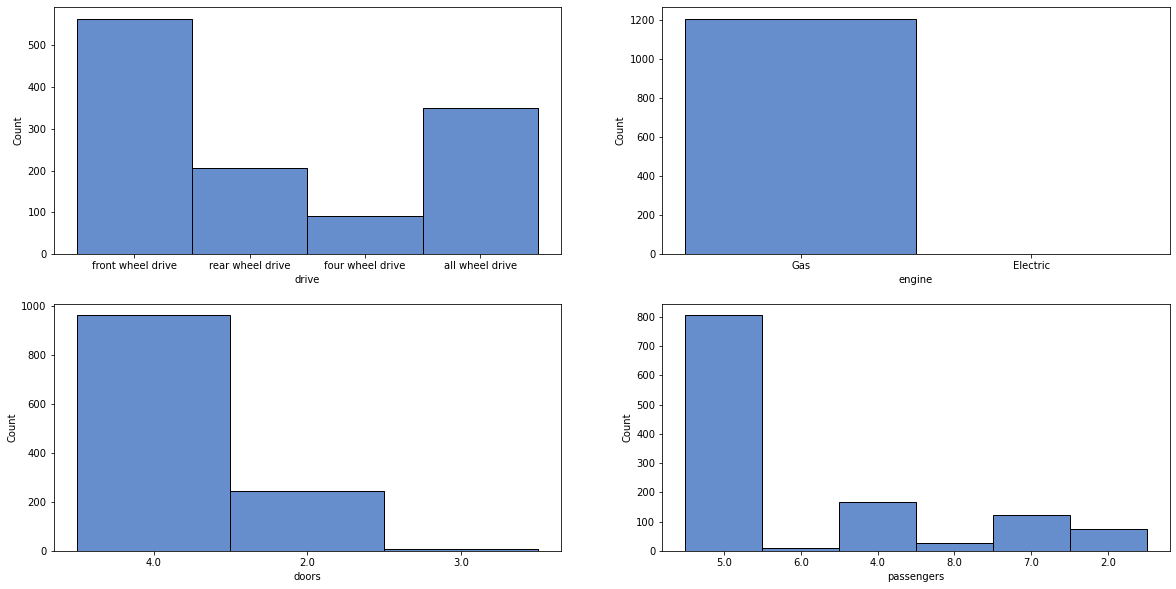

In [12]:
# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 2, wspace=0.2)
plt.figure(figsize=(20,10))

ax = plt.subplot(gs[0, 0]) # row 0, col 0
sns.histplot(x=df1['drive'], color = '#3468bc')

ax = plt.subplot(gs[0, 1]) # row 0, col 1
sns.histplot(x=df1['engine'], color = '#3468bc')

ax = plt.subplot(gs[1, 0]) # row 0, col 3
sns.histplot(x=df1['doors'], color = '#3468bc')

ax = plt.subplot(gs[1, 1]) # row 0, col 3
sns.histplot(x=df1['passengers'], color = '#3468bc')

#### Intial Takeaways

###### What is the distribution of the target?

heavily skewed to the left, not normal

##### Are there any colinearities in the feartures?

* Price

##### What are the relationships between each features and the targets

So far there does not appear to be any obvious linear relationships between features and the target

# Modeling

### Baseline Model

define features(X) and Target(y)

In [13]:
X = df1[[ 'doors', 'passengers','price', 'speed_sec', 'horsepower_hp', 'drive', 'mpg', 'engine', 'tank_gal',
                  'length_in', 'width_in','height_in', 'wheelbase_in']]

y = df1['Total_Sales']

X = pd.get_dummies(X)

split data into train and test data 

In [14]:
# hold out 20% of the data for final testing
#change random state for new subset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46)

In [15]:
#baseline linear model with cross validation
lm = linear_regression_with_cv(X_train,y_train)

Simple mean cv r^2 train score: 0.183 +- 0.007
Simple mean cv r^2 val score: 0.149 +- 0.022
Simple mean cv adjusted r^2 val score: 0.027 +- 0.025
Simple mean cv mae: 37783.631 +- 2715.898


In [16]:
#baseline polynomial model with interaction terms only
poly = polynomial_regression_with_cv(X_train,y_train, 2, True)

Results for 2 degree, interaction_only = True polynomial regression:
Simple mean cv r^2 train score: 0.357 +- 0.136
Simple mean cv r^2 val score: -2.602 +- 1.518
Simple mean cv adjusted r^2 val score: 7.378 +- 2.702
Simple mean cv mae: 48824.390 +- 6638.333


Severely negative R^2 score for polynomial regression tells us that the model is overfit and that evidence points towards a simple linear regression model.

In [17]:
#baseline lassocv
lasso = scaled_lasso_cv(5, 700, 900, 2, X_train, y_train, X_test, y_test)
#get coeficients to see if any zeroed out
get_feature_coefs(model=lasso,linear=True,X_train=X_train)

Alpha: 700
MAE test value: 37109.22871066785
Adjusted r2 test score: 0.050479986096326646
R2 test score: 0.14503799577968002
R2 train score: 0.17652564151677486
Feature coefficient results: 

Coef of price is : -215.58
Coef of speed_sec is : 685.94
Coef of horsepower_hp is : -2283.63
Coef of mpg is : 0.00
Coef of tank_gal is : -6238.41
Coef of length_in is : 3241.99
Coef of width_in is : -1927.05
Coef of height_in is : -4504.96
Coef of wheelbase_in is : 932.75
Coef of doors_2.0 is : -0.00
Coef of doors_3.0 is : -290.55
Coef of doors_4.0 is : 5288.42
Coef of passengers_2.0 is : -6531.37
Coef of passengers_4.0 is : -6629.80
Coef of passengers_5.0 is : 0.00
Coef of passengers_6.0 is : 562.24
Coef of passengers_7.0 is : 1780.54
Coef of passengers_8.0 is : 8678.46
Coef of drive_all wheel drive is : -2571.33
Coef of drive_four wheel drive is : 2802.08
Coef of drive_front wheel drive is : 4786.27
Coef of drive_rear wheel drive is : -0.00
Coef of engine_Electric is : -885.27
Coef of engine_Gas

MPG, speed_sec, doors_2, passengers_5, rear wheel drive, and gas engine is zeroed

### Feature Engineering

Only observing adjusted r2 score for feature engineering

In [18]:
X_train2 = X_train.copy()
X_test2 = X_test.copy()

#drop columns that were zeroed out per baseline lassocv model
X_train2 = X_train2.drop(labels=['mpg', 'speed_sec' ,'drive_rear wheel drive', 'engine_Gas', 'doors_2.0',
                                  'passengers_5.0'], axis=1)
X_test2 = X_test2.drop(labels=['mpg', 'speed_sec','drive_rear wheel drive', 'engine_Gas', 'doors_2.0',
                                  'passengers_5.0'], axis=1)

current_adj_r2 = 0.027
print(f'Current adj r2 score: {current_adj_r2}')
lm2 = linear_regression_with_cv(X_train2,y_train)
current_adj_r2 = 0.069

Current adj r2 score: 0.027
Simple mean cv r^2 train score: 0.183 +- 0.007
Simple mean cv r^2 val score: 0.156 +- 0.024
Simple mean cv adjusted r^2 val score: 0.069 +- 0.027
Simple mean cv mae: 37632.819 +- 2709.576


Split length width and height into smaller and larger catergories

<AxesSubplot:xlabel='height_in', ylabel='Total_Sales'>

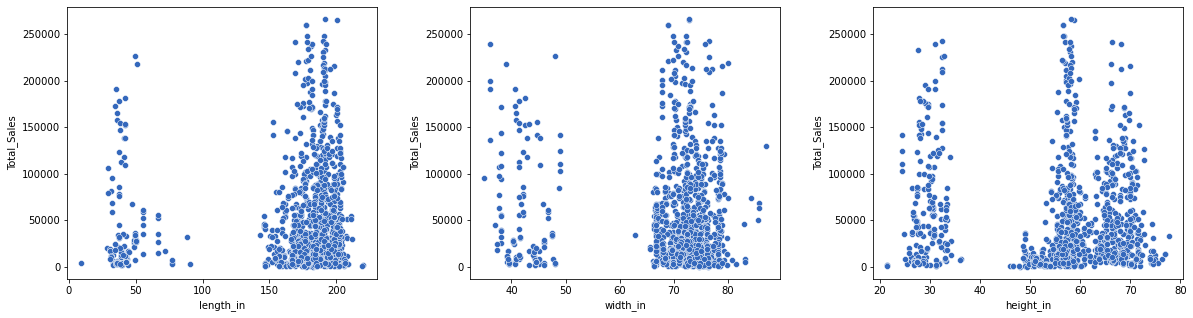

In [19]:
# Create 2x2 sub plots
gs = gridspec.GridSpec(1, 3, wspace=0.3)
plt.figure(figsize=(20,5))

ax = plt.subplot(gs[0, 0]) # row 0, col 0
sns.scatterplot(x = df1['length_in'], y = df1['Total_Sales'], color = '#3468bc')

ax = plt.subplot(gs[0, 1]) # row 0, col 1
sns.scatterplot(x=df1['width_in'], y=df1['Total_Sales'], color = '#3468bc')

ax = plt.subplot(gs[0, 2]) # row 0, col 3
sns.scatterplot(x=df1['height_in'], y=df1['Total_Sales'], color = '#3468bc')

In [37]:
#split length by 120 inches
X_train3 = X_train2.copy()
X_test3 = X_test2.copy()

X_train3['length_low'] = X_train3['length_in']*(X_train3['length_in']<120)
X_test3['length_low'] = X_test3['length_in']*(X_test3['length_in']<120)

X_train3['length_hi'] = X_train3['length_in']*(X_train3['length_in']>=120)
X_test3['length_hi'] = X_test3['length_in']*(X_test3['length_in']>=120)

#split width by 55 inches
X_train3['width_low'] = (X_train3['width_in']*(X_train3['width_in']<55))
X_test3['width_low'] = (X_test3['width_in']*(X_test3['width_in']<55))

X_train3['width_hi'] = (X_train3['width_in']*(X_train3['width_in']>=55))
X_test3['width_hi'] = (X_test3['width_in']*(X_test3['width_in']>=55))

#split height by 40 inches
X_train3['height_low'] = (X_train3['height_in']*(X_train3['height_in']<40))
X_test3['height_low'] = X_test3['height_in']*(X_test3['height_in']<40)

X_train3['height_hi'] = X_train3['height_in']*(X_train3['height_in']>=40)
X_test3['height_hi'] = X_test3['height_in']*(X_test3['height_in']>=40)

X_train3 = X_train3.drop(labels=['height_in', 'width_in', 'length_in'], axis=1)
X_test3 = X_test3.drop(labels=['height_in', 'width_in', 'length_in'], axis=1)

print(f'Current adj r2 score: {current_adj_r2}')
linear_regression_with_cv(X_train3,y_train)
current_adj_r2 = 0.066

Current adj r2 score: 0.086
Simple mean cv r^2 train score: 0.198 +- 0.006
Simple mean cv r^2 val score: 0.168 +- 0.018
Simple mean cv adjusted r^2 val score: 0.066 +- 0.020
Simple mean cv mae: 37314.871 +- 2766.443


adj r2 went down because more features were added. Lets look at the relationshio between the 6 new columns

<ipython-input-21-829a9103a73f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Total_Sales'] = y_train.copy()


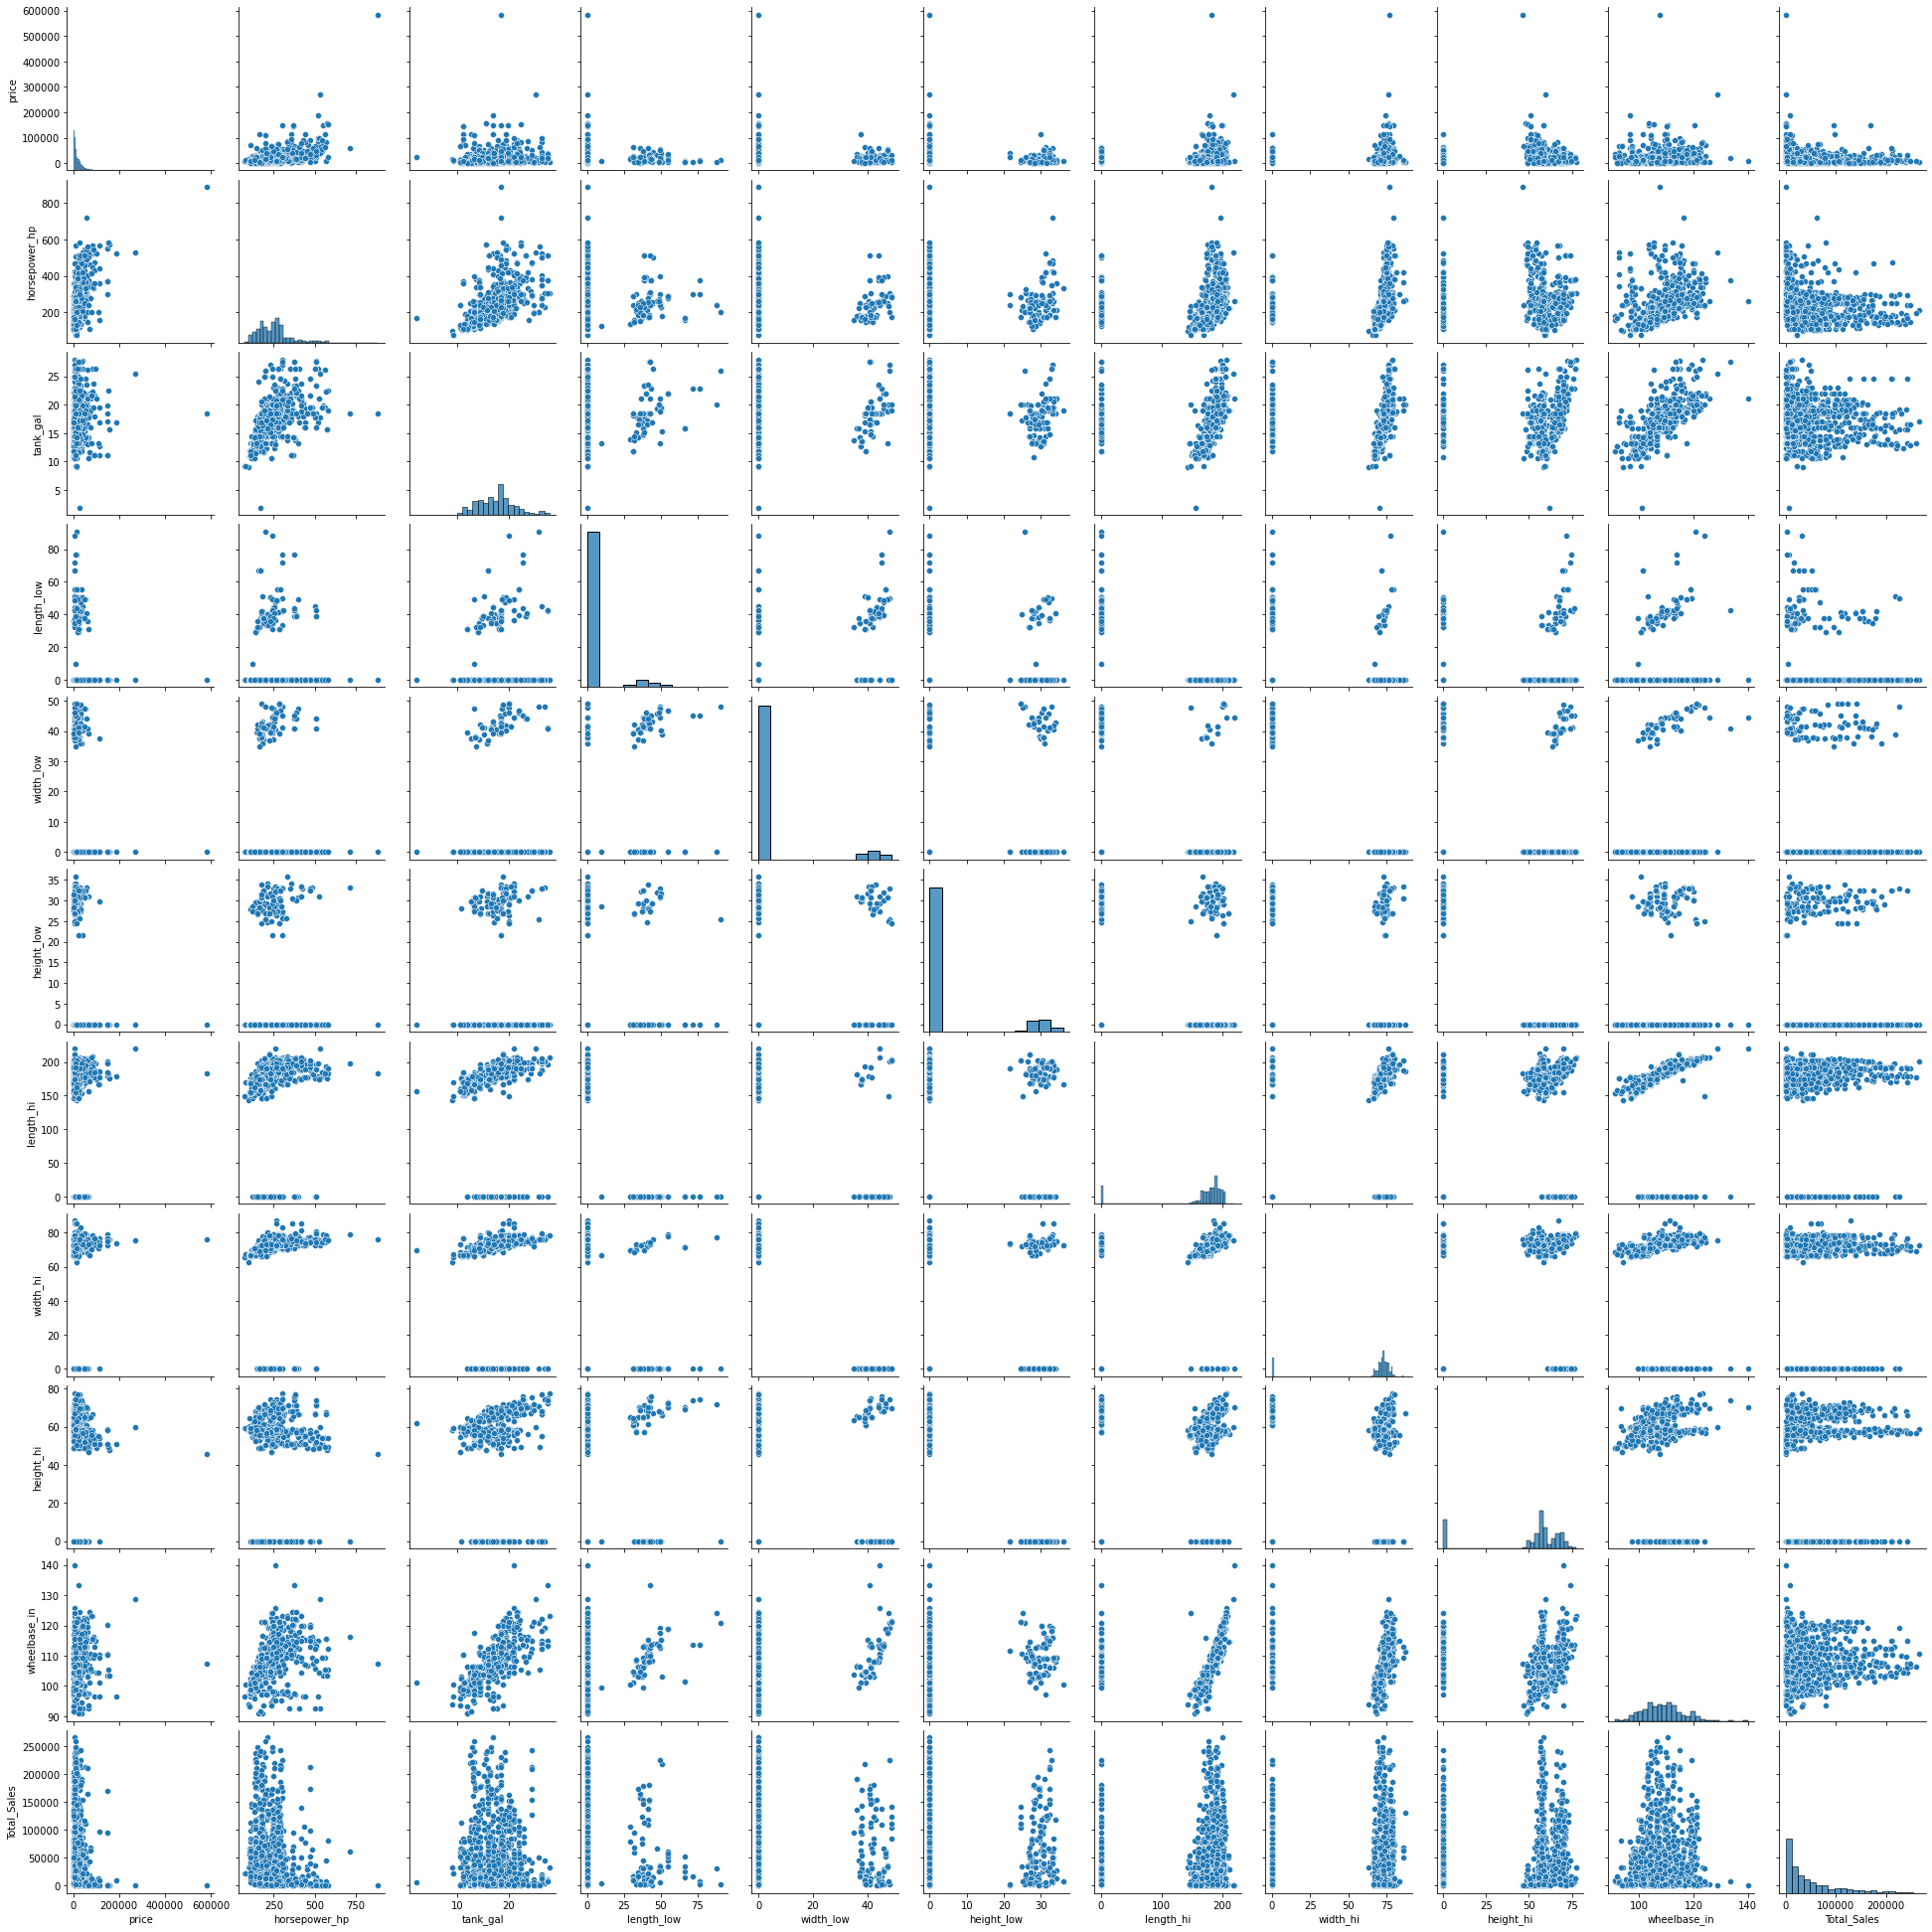

In [21]:
df3 = X_train3[[ 'price',  'horsepower_hp',  
                       'tank_gal', 'length_low', 'width_low','height_low', 'length_hi', 'width_hi','height_hi', 
                       'wheelbase_in']]
df3['Total_Sales'] = y_train.copy()
sns.pairplot(df3)

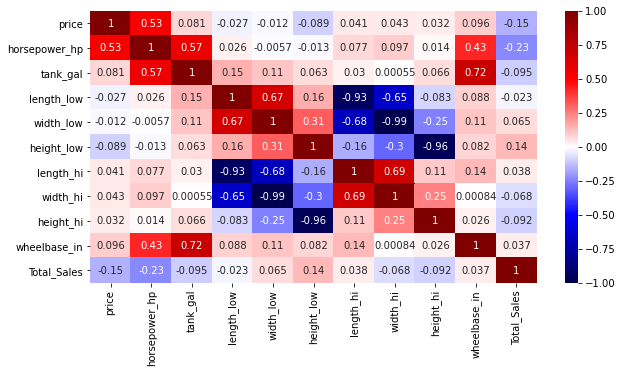

In [22]:
plt.figure(figsize=(10,5))
sns.heatmap(df3.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

* tank_gal and wheel_base are collinear
* wheelbase and horsepower are collinear
* width_hi and length_hi are collinear
* width_low and length_low are collinear
* horsepower and tank_gal collinear
* horsepower and price are collinear

In [39]:
#Hi length/width categories and low length/width features were very highly collinear
X_train4 = X_train3.copy()
X_test4 = X_test3.copy()

#create small lengthxwidth columns
X_train4['small_lxw'] = X_train3['length_low']*X_train3['width_low'] 
X_test4['small_lxw'] = X_test3['length_low']*X_test3['width_low'] 

#create large lengthxwidth columns
X_train4['large_lxw'] = X_train3['length_hi']*X_train3['width_hi'] 
X_test4['large_lxw'] = X_test3['length_hi']*X_test3['width_hi'] 

#drop length/wdith columns
X_train4 = X_train4.drop(labels=['length_hi', 'width_hi',  'length_low', 'width_low'], axis=1)
X_test4 = X_test4.drop(labels=['length_hi', 'width_hi', 'length_low', 'width_low'], axis=1)

print(f'Current adj r2 score: {current_adj_r2}')
linear_regression_with_cv(X_train4,y_train)
current_adj_r2 = 0.076

Current adj r2 score: 0.076
Simple mean cv r^2 train score: 0.190 +- 0.005
Simple mean cv r^2 val score: 0.167 +- 0.013
Simple mean cv adjusted r^2 val score: 0.076 +- 0.015
Simple mean cv mae: 37503.089 +- 2626.669


In [40]:
#drop collinear columns
X_train4 = X_train4.drop(labels=['wheelbase_in', 'horsepower_hp'], axis=1)
X_test4 = X_test4.drop(labels=['wheelbase_in', 'horsepower_hp'], axis=1)

print(f'Current adj r2 score: {current_adj_r2}')
linear_regression_with_cv(X_train4,y_train)
current_adj_r2 = 0.086

Current adj r2 score: 0.076
Simple mean cv r^2 train score: 0.187 +- 0.005
Simple mean cv r^2 val score: 0.167 +- 0.013
Simple mean cv adjusted r^2 val score: 0.086 +- 0.015
Simple mean cv mae: 37312.873 +- 2642.752


Perform BoxCox transformation on non-normally distributed features

In [41]:
X_train5 = X_train4.copy()
X_test5 = X_test4.copy()

#transform price feature into normal distribution data & save lambda value 
fitted_train_data, fitted_train_lambda = stats.boxcox(X_train5['price']) 
fitted_test_data, fitted_test_lambda = stats.boxcox(X_test5['price']) 
X_train5['price_boxcox'] = fitted_train_data
X_test5['price_boxcox'] = fitted_test_data

#drop price columns
X_train5 = X_train5.drop(labels=['price'], axis=1)
X_test5 = X_test5.drop(labels=['price'], axis=1)

print(f'Current adj r2 score: {current_adj_r2}')
linear_regression_with_cv(X_train5,y_train)
current_adj_r2 = 0.086

Current adj r2 score: 0.086
Simple mean cv r^2 train score: 0.188 +- 0.005
Simple mean cv r^2 val score: 0.167 +- 0.013
Simple mean cv adjusted r^2 val score: 0.086 +- 0.014
Simple mean cv mae: 37327.951 +- 2687.607


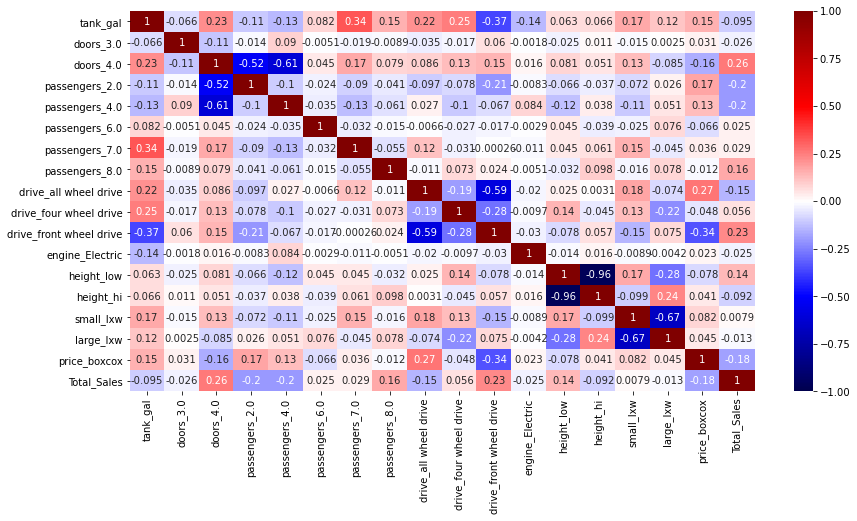

In [42]:
df4 = X_train5.copy()
df4['Total_Sales'] = y_train.copy()
plt.figure(figsize=(14,7))
sns.heatmap(df4.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

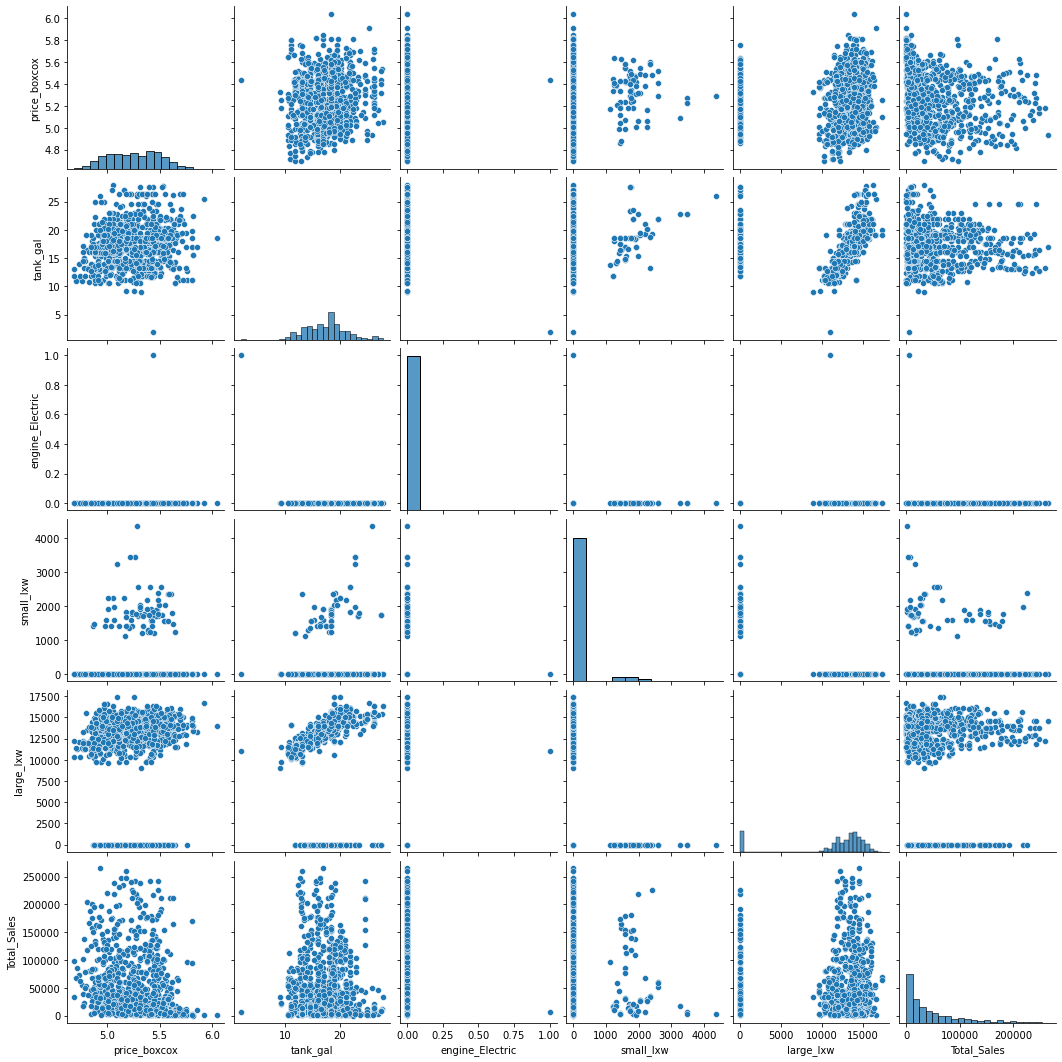

In [43]:
sns.pairplot(df4[['price_boxcox','tank_gal','engine_Electric', 'small_lxw', 'large_lxw', 'Total_Sales']])

### Model Selection

Use X_train5 and X_test5 for model selection and final testing, Only observe regular r2 values when choosing model

In [44]:
#Linear model with cross validation
lm = linear_regression_with_cv(X_train5,y_train) #0.167 r2 validation score

Simple mean cv r^2 train score: 0.188 +- 0.005
Simple mean cv r^2 val score: 0.167 +- 0.013
Simple mean cv adjusted r^2 val score: 0.086 +- 0.014
Simple mean cv mae: 37327.951 +- 2687.607


In [45]:
#Polynomial model with cross validation and interaction terms only
pm = polynomial_regression_with_cv(X_train5,y_train,2,True)

Results for 2 degree, interaction_only = True polynomial regression:
Simple mean cv r^2 train score: 0.329 +- 0.019
Simple mean cv r^2 val score: -0.765 +- 1.023
Simple mean cv adjusted r^2 val score: -7.850 +- 5.151
Simple mean cv mae: 41140.927 +- 3897.188


In [46]:
#Polynomial model with cross validation and 2n degree interaction terms
pm2 = polynomial_regression_with_cv(X_train5,y_train,2,False)

Results for 2 degree, interaction_only = False polynomial regression:
Simple mean cv r^2 train score: 0.302 +- 0.102
Simple mean cv r^2 val score: -0.723 +- 0.898
Simple mean cv adjusted r^2 val score: -14.487 +- 8.039
Simple mean cv mae: 42666.146 +- 5218.322


In [47]:
#Ridge model with cross validation and without scaling
ridge = manual_ridge_cv(X_train5, y_train, 1) #0.156 r2 val score
ridge = manual_ridge_cv(X_train5, y_train, 500)
ridge = manual_ridge_cv(X_train5, y_train, 1000)

Ridge regression results for aplpha = 1:
R^2 Train: 0.18859999999999996,
R^2 Val: 0.15619999999999998,
Adjusted R^2 Val: 0.0744,
MAE: 37537.3312,
Ridge regression results for aplpha = 500:
R^2 Train: 0.1282,
R^2 Val: 0.11740000000000002,
Adjusted R^2 Val: 0.0314,
MAE: 38652.90559999999,
Ridge regression results for aplpha = 1000:
R^2 Train: 0.11300000000000002,
R^2 Val: 0.1032,
Adjusted R^2 Val: 0.016599999999999997,
MAE: 39114.883799999996,


In [48]:
#lasso model with cross validation and without scaling
lasso = manual_lasso_cv(X_train5, y_train, 1) #0.155 r2 val score
lasso = manual_lasso_cv(X_train5, y_train, 500)
lasso = manual_lasso_cv(X_train5, y_train, 1000)

Lasso regression results for aplpha = 1:
R^2 Train: 0.18919999999999998,
R^2 Val: 0.15560000000000002,
Adjusted R^2 Val: 0.0736,
MAE: 37569.458999999995,
Lasso regression results for aplpha = 500:
R^2 Train: 0.1756,
R^2 Val: 0.1512,
Adjusted R^2 Val: 0.0688,
MAE: 37572.176600000006,
Lasso regression results for aplpha = 1000:
R^2 Train: 0.15860000000000002,
R^2 Val: 0.1398,
Adjusted R^2 Val: 0.056600000000000004,
MAE: 37891.9398,


In [49]:
#Ridge model with cross validation and scaled
ridge = manual_scaled_ridge_cv(X_train5, y_train, 50) #0.156 r2 val score
ridge = manual_scaled_ridge_cv(X_train5, y_train, 100)
ridge = manual_scaled_ridge_cv(X_train5, y_train, 150)

Ridge regression results for aplpha = 50:
R^2 Train: 0.18659999999999996,
R^2 Val: 0.156,
Adjusted R^2 Val: 0.0744,
MAE: 37552.652,
Ridge regression results for aplpha = 100:
R^2 Train: 0.18439999999999998,
R^2 Val: 0.156,
Adjusted R^2 Val: 0.0746,
MAE: 37536.1164,
Ridge regression results for aplpha = 150:
R^2 Train: 0.1822,
R^2 Val: 0.1558,
Adjusted R^2 Val: 0.074,
MAE: 37539.529800000004,


In [50]:
#lasso model with cross validation and scaled
lasso = manual_scaled_lasso_cv(X_train5, y_train, 1) #0.155 r2 val score
lasso = manual_scaled_lasso_cv(X_train5, y_train, 500)
lasso = manual_scaled_lasso_cv(X_train5, y_train, 1000)

Lasso regression results for aplpha = 1:
R^2 Train: 0.18919999999999998,
R^2 Val: 0.15539999999999998,
Adjusted R^2 Val: 0.0736,
MAE: 37569.984,
Lasso regression results for aplpha = 500:
R^2 Train: 0.1854,
R^2 Val: 0.15299999999999997,
Adjusted R^2 Val: 0.0708,
MAE: 37582.116200000004,
Lasso regression results for aplpha = 1000:
R^2 Train: 0.18,
R^2 Val: 0.14980000000000002,
Adjusted R^2 Val: 0.0678,
MAE: 37611.3338,


In [51]:
#lasso model with scaled polynomial features and cross validated
#create polynomial features
poly = PolynomialFeatures(degree=2, interaction_only = True)
X_train_poly = poly.fit_transform(X_train5)

lasso = manual_scaled_lasso_cv(X_train_poly, y_train, 2000)
lasso = manual_scaled_lasso_cv(X_train_poly, y_train, 2100) #0.15
lasso = manual_scaled_lasso_cv(X_train_poly, y_train, 2200) 

Lasso regression results for aplpha = 2000:
R^2 Train: 0.1942,
R^2 Val: 0.15040000000000003,
Adjusted R^2 Val: -3.2561999999999998,
MAE: 37615.559799999995,
Lasso regression results for aplpha = 2100:
R^2 Train: 0.1928,
R^2 Val: 0.15080000000000002,
Adjusted R^2 Val: -3.255,
MAE: 37627.676,
Lasso regression results for aplpha = 2200:
R^2 Train: 0.19119999999999998,
R^2 Val: 0.1506,
Adjusted R^2 Val: -3.2546,
MAE: 37643.9976,


#### Linear regression model performs the best

### Final Model

In [52]:
#find scores for testing data

print(f'R^2 Val: {r2_value(X_test5, y_test, lm)},\n')
print(f'MAE: {mae_value(X_test5, y_test, lm)},')

R^2 Val: 0.07231656143746867,

MAE: 42901.538051862815,


In [53]:
get_feature_coefs(lm,True,X_train5)

Feature coefficient results: 

Coef of tank_gal is : -3450.39
Coef of doors_3.0 is : -14395.69
Coef of doors_4.0 is : 15320.80
Coef of passengers_2.0 is : -20121.37
Coef of passengers_4.0 is : -13307.06
Coef of passengers_6.0 is : 14538.31
Coef of passengers_7.0 is : 10655.17
Coef of passengers_8.0 is : 59742.88
Coef of drive_all wheel drive is : -6036.84
Coef of drive_four wheel drive is : 8490.01
Coef of drive_front wheel drive is : 9281.00
Coef of engine_Electric is : -77479.68
Coef of height_low is : 2195.03
Coef of height_hi is : 715.89
Coef of small_lxw is : 3.04
Coef of large_lxw is : 1.29
Coef of price_boxcox is : -10263.34


Final Model testing on testing data showed significant decresse in r2 compared to validation score. When model was ran in a previous state r2 test score was much higher. This indicates that the model is not a good fit and all car specs examined are not good predictors of the total number of cars sold in a year. More 